In [1]:
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import os
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms as tf
from os import walk
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import image
# Set ipython's max row display
pd.set_option('display.max_row', 1000)

# Set iPython's max column width to 50
pd.set_option('display.max_columns', 50)

In [2]:
train_list_df = pd.read_csv('train_val_list.txt', header=None, names=['Image Index'])
test_list_df = pd.read_csv('test_list.txt', header=None, names=['Image Index'])
xray_train_df = pd.read_csv('BBox_List_2017.csv')
xray_test_df = pd.read_csv('Data_entry_2017_v2020.csv')

In [44]:
train_list_df.head(10)

,Image Index
0,00000001_000.png
1,00000001_001.png
2,00000001_002.png
3,00000002_000.png
4,00000004_000.png
5,00000005_000.png
6,00000005_001.png
7,00000005_002.png
8,00000005_003.png
9,00000005_004.png


In [64]:
train_list_df.shape, test_list_df.shape

((86524, 1), (25596, 1))

In [60]:
xray_test_df['Image Index'].isin(train_list_df['Image Index']).value_counts()

True     86524
False    25596
Name: Image Index, dtype: int64

In [61]:
xray_train_df['Image Index'].isin(train_list_df['Image Index']).value_counts()

False    984
Name: Image Index, dtype: int64

In [63]:
xray_test_df['Image Index'].isin(test_list_df['Image Index']).value_counts()

False    86524
True     25596
Name: Image Index, dtype: int64

In [62]:
xray_train_df['Image Index'].isin(test_list_df['Image Index']).value_counts()

True    984
Name: Image Index, dtype: int64

In [4]:
test_list_df.sample(10)

,Image Index
4119,00006713_012.png
18793,00022141_021.png
14471,00017236_044.png
1085,00001437_050.png
8676,00012364_027.png
16005,00018867_030.png
22535,00028549_002.png
25139,00030394_003.png
18809,00022155_004.png
20401,00025787_010.png


In [5]:
xray_test_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168
...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,38,M,PA,2048,2500,0.168,0.168
112116,00030802_000.png,No Finding,0,30802,28,M,PA,2048,2500,0.168,0.168
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168
112118,00030804_000.png,No Finding,0,30804,29,F,PA,2048,2500,0.168,0.168


In [6]:
xray_test_df.columns

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]'],
      dtype='object')

In [7]:
my_list = []
for each in xray_test_df["Finding Labels"].str.split('|'):
    my_list += each
my_unique_list = set(my_list)

In [8]:
# new = xray_test_df["Finding Labels"].str.split("|", n = 9, expand = True)
# new.sample(20)

In [9]:
# xray_test_df['Finding Labels'] = xray_test_df["Finding Labels"].str.split("|")

In [10]:
def search_me(df_series, term):
    return 1 if term in df_series.split('|') else 0

In [11]:
for each_disease in my_unique_list:
    xray_test_df[each_disease] = xray_test_df["Finding Labels"].apply(search_me, args=(each_disease,))
xray_test_df = xray_test_df.drop('Finding Labels', axis=1)

In [12]:
def my_hot_encoding(dataframe, feature_list_to_encode):
    encoding_dict = {}
    for each_feature in feature_list_to_encode:
        feature_dict = {}
        for index_type, each_type in enumerate(dataframe[each_feature].unique()):
            feature_dict[each_type] = index_type
        encoding_dict[each_feature] = feature_dict
    for each_feature in feature_list_to_encode:
        dataframe[each_feature] = dataframe[each_feature].map(lambda x: encoding_dict[each_feature][x])
    dataframe[each_feature].astype(np.int64)
    return encoding_dict  

In [13]:
gender = my_hot_encoding(xray_test_df, ['Patient Gender'])

In [14]:
view_position = my_hot_encoding(xray_test_df, ['View Position'])

In [15]:
xray_test_df.sample(20)

,Image Index,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Mass,Fibrosis,Pneumonia,Edema,Nodule,Pleural_Thickening,Consolidation,Effusion,Cardiomegaly,Emphysema,Hernia,Infiltration,No Finding,Pneumothorax,Atelectasis
22755,00006013_004.png,4,6013,52,0,0,2992,2991,0.143,0.143,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
27562,00007171_001.png,1,7171,49,1,1,2500,2048,0.168,0.168,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
46376,00011850_017.png,17,11850,40,0,1,2500,2048,0.168,0.168,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
92458,00023081_002.png,2,23081,53,0,1,3056,2544,0.139,0.139,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
53219,00013442_000.png,0,13442,37,1,0,2384,2302,0.143,0.143,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
5347,00001429_004.png,4,1429,60,1,0,2526,2477,0.143,0.143,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
80018,00019650_004.png,3,19650,33,0,0,2992,2991,0.143,0.143,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
67805,00016754_002.png,2,16754,32,1,0,2992,2991,0.143,0.143,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
64997,00016051_008.png,8,16051,29,1,0,2048,2500,0.168,0.168,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
11032,00002860_014.png,14,2860,46,1,1,2500,2048,0.168,0.168,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [16]:
# xray_test_other_view_df = pd.pivot_table(xray_test_df, index=['Patient ID', 'Follow-up #', 'Image Index'])
# xray_test_other_view_df.head(20)

In [20]:
xray_train_df.isna().count()

Image Index      984
Finding Label    984
Bbox [x          984
y                984
w                984
h]               984
Unnamed: 6       984
Unnamed: 7       984
Unnamed: 8       984
dtype: int64

In [21]:
xray_train_df = xray_train_df.dropna(axis=1)
xray_train_df.sample(10)

,Image Index,Finding Label,Bbox [x,y,w,h]
398,00017403_006.png,Effusion,594.895238,576.474074,191.796825,304.491005
698,00013673_001.png,Nodule,150.620106,435.606349,81.269841,70.433862
699,00004911_018.png,Nodule,695.669841,319.661376,100.774603,88.855026
722,00017346_000.png,Nodule,873.379894,615.483598,28.173545,33.591534
743,00013751_003.png,Nodule,676.165079,610.065608,89.938624,89.938624
109,00014447_004.png,Atelectasis,212.385185,421.519577,163.623280,96.440212
154,00021862_004.png,Atelectasis,607.898413,559.136508,118.112169,135.449735
115,00027556_007.png,Atelectasis,172.292063,645.824339,138.700529,114.861376
161,00005066_030.png,Cardiomegaly,277.152542,459.154810,540.203390,301.559322
237,00018686_000.png,Cardiomegaly,353.252910,307.741799,497.371429,452.943915


In [22]:
def search_me2(df_series, term):
    return 1 if term in df_series else 0

In [24]:
for each_disease in my_unique_list:
    xray_train_df[each_disease] = xray_train_df["Finding Label"].apply(search_me2, args=(each_disease,))
xray_train_df = xray_train_df.drop('Finding Label', axis=1)

In [25]:
xray_train_df.sample(20)

,Image Index,Bbox [x,y,w,h],Mass,Fibrosis,Pneumonia,Edema,Nodule,Pleural_Thickening,Consolidation,Effusion,Cardiomegaly,Emphysema,Hernia,Infiltration,No Finding,Pneumothorax,Atelectasis
768,00013391_005.png,101.831111,314.349045,307.200000,364.088889,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
762,00029431_000.png,189.440000,440.642378,218.453333,410.737778,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
671,00023068_003.png,351.085714,747.682540,35.758730,33.591534,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
523,00000211_016.png,237.307937,465.947090,230.806349,328.330159,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
739,00002290_001.png,260.063492,717.341799,63.932275,47.678307,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
884,00021748_000.png,550.115556,74.277934,167.253333,54.613333,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
877,00029909_003.png,167.822222,168.713490,233.244444,89.884444,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
798,00003789_000.png,272.497778,569.211267,100.124444,93.297778,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
497,00016705_006.png,691.200000,308.660156,95.573333,237.795556,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
857,00018063_000.png,282.819048,387.928042,185.295238,173.375661,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [66]:
xray_test_df.columns

Index(['Image Index', 'Follow-up #', 'Patient ID', 'Patient Age',
       'Patient Gender', 'View Position', 'OriginalImage[Width', 'Height]',
       'OriginalImagePixelSpacing[x', 'y]', 'Mass', 'Fibrosis', 'Pneumonia',
       'Edema', 'Nodule', 'Pleural_Thickening', 'Consolidation', 'Effusion',
       'Cardiomegaly', 'Emphysema', 'Hernia', 'Infiltration', 'No Finding',
       'Pneumothorax', 'Atelectasis'],
      dtype='object')

In [67]:
xray_train_df.columns

Index(['Image Index', 'Bbox [x', 'y', 'w', 'h]', 'Mass', 'Fibrosis',
       'Pneumonia', 'Edema', 'Nodule', 'Pleural_Thickening', 'Consolidation',
       'Effusion', 'Cardiomegaly', 'Emphysema', 'Hernia', 'Infiltration',
       'No Finding', 'Pneumothorax', 'Atelectasis'],
      dtype='object')

In [71]:
xray_test_2df = xray_test_df[['Image Index','OriginalImage[Width', 'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Mass', 'Fibrosis', 'Pneumonia',
       'Edema', 'Nodule', 'Pleural_Thickening', 'Consolidation', 'Effusion', 'Cardiomegaly', 'Emphysema', 'Hernia', 
       'Infiltration', 'Pneumothorax', 'Atelectasis']]

In [72]:
xray_train_2df = xray_train_df[['Image Index', 'Bbox [x', 'y', 'w', 'h]', 'Mass', 'Fibrosis',
       'Pneumonia', 'Edema', 'Nodule', 'Pleural_Thickening', 'Consolidation',
       'Effusion', 'Cardiomegaly', 'Emphysema', 'Hernia', 'Infiltration', 'Pneumothorax', 'Atelectasis']]

In [83]:
xray_train_2df = xray_train_df.rename(columns={'Bbox [x': 'x', 'h]': 'h'})

In [84]:
xray_train_2df.sample(10)

,Image Index,x,y,w,h,Mass,Fibrosis,Pneumonia,Edema,Nodule,Pleural_Thickening,Consolidation,Effusion,Cardiomegaly,Emphysema,Hernia,Infiltration,No Finding,Pneumothorax,Atelectasis
61,00005089_002.png,648.135593,574.137861,263.593220,188.745763,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
123,00014253_010.png,36.842328,247.060317,245.976720,83.437037,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
198,00012741_004.png,442.033898,434.711864,446.915254,407.864407,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
35,00016267_000.png,178.440678,599.087013,232.135593,216.949153,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
410,00022572_063.png,70.433862,517.959788,282.819048,319.661376,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
841,00007444_003.png,626.319577,418.268783,229.722751,241.642328,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
584,00029579_005.png,609.280000,189.193490,73.955556,71.680000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
780,00023283_005.png,548.977778,486.153490,218.453333,225.280000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
610,00028027_000.png,575.146667,247.220156,118.328889,144.497778,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
593,00018623_001.png,277.048889,498.669045,612.124444,258.275556,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [79]:
xray_test_2df = xray_test_2df.rename(columns={'OriginalImage[Width': 'w', 'Height]': 'h', 'OriginalImagePixelSpacing[x': 'x', 'y]':'y'})

In [80]:
xray_test_2df.sample(10)

,Image Index,w,h,x,y,Mass,Fibrosis,Pneumonia,Edema,Nodule,Pleural_Thickening,Consolidation,Effusion,Cardiomegaly,Emphysema,Hernia,Infiltration,Pneumothorax,Atelectasis
43822,00011293_004.png,2500,2048,0.168000,0.168000,0,0,0,0,0,0,0,0,0,0,0,0,0,0
65481,00016169_000.png,2678,2503,0.143000,0.143000,0,0,0,0,0,0,0,0,0,0,0,0,0,0
104734,00028060_001.png,2021,2021,0.194311,0.194311,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5809,00001558_039.png,2992,2991,0.143000,0.143000,0,0,0,0,0,0,0,0,0,0,0,0,0,0
34325,00009018_000.png,2048,2500,0.168000,0.168000,0,0,0,0,0,0,0,0,0,0,0,0,0,0
84974,00020945_051.png,3056,2544,0.139000,0.139000,0,0,0,0,0,0,0,0,0,0,0,1,0,0
31274,00008156_001.png,2500,2048,0.168000,0.168000,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27807,00007239_001.png,2500,2048,0.171000,0.171000,0,0,0,0,0,0,0,0,0,0,0,0,0,0
62037,00015354_001.png,2992,2991,0.143000,0.143000,0,0,0,0,0,0,0,0,0,0,0,0,0,0
99398,00026292_007.png,2021,2020,0.194311,0.194311,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [90]:
train_df = xray_test_2df[xray_test_2df['Image Index'].isin(train_list_df['Image Index'])]

In [98]:
train_df.to_csv('train_df.csv', index=False)

In [91]:
test_df = xray_test_2df[xray_test_2df['Image Index'].isin(test_list_df['Image Index'])]

In [95]:
test_df = test_df.append(xray_train_2df[xray_train_2df['Image Index'].isin(test_list_df['Image Index'])], ignore_index=True)

In [ ]:
test_df.to_csv('test_df.csv', index=False)

In [96]:
test_df.shape

(26580, 20)

In [97]:
test_df.sample(10)

,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Image Index,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,h,w,x,y
7760,0,0,0,0,0,0,0,0,00011579_031.png,0,0,NaN,0,0,0,0,2048.0,2500.0,0.168000,0.168000
3658,0,0,0,0,0,0,0,0,00005801_009.png,0,0,NaN,0,0,0,0,2991.0,2992.0,0.143000,0.143000
11520,0,0,0,0,0,0,0,0,00014525_000.png,0,0,NaN,0,1,0,0,2544.0,3056.0,0.139000,0.139000
21962,0,0,0,0,0,0,0,0,00028148_000.png,1,0,NaN,0,0,0,0,3056.0,2544.0,0.139000,0.139000
5045,0,0,0,0,0,0,0,0,00008295_027.png,0,0,NaN,0,0,0,0,2048.0,2500.0,0.168000,0.168000
15923,0,0,0,0,0,0,0,0,00018860_000.png,1,0,NaN,0,1,0,0,2021.0,2021.0,0.194311,0.194311
25524,0,0,0,0,0,0,0,0,00030707_000.png,0,0,NaN,0,0,0,0,2021.0,1941.0,0.194311,0.194311
20089,0,0,0,0,0,0,0,0,00025228_000.png,0,0,NaN,0,0,0,0,2991.0,2546.0,0.143000,0.143000
391,0,1,0,0,0,0,0,0,00000377_000.png,0,0,NaN,0,0,0,0,2965.0,2690.0,0.143000,0.143000
20617,1,0,0,0,0,0,0,0,00026194_010.png,1,0,NaN,0,0,0,0,3056.0,2544.0,0.139000,0.139000


In [27]:
img.size

(1024, 1024)

In [28]:
transforms = tf.Compose([tf.Resize(400),
                         tf.ToTensor()])

In [29]:
img_transformed_to_tensor = transforms(img)

In [30]:
img_transformed_to_tensor.shape

torch.Size([1, 400, 400])

In [31]:
img_for_plot = img_transformed_to_tensor.squeeze()
img_for_plot.shape

torch.Size([400, 400])

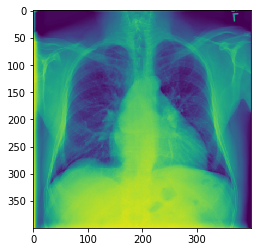

In [32]:
plt.imshow(img_for_plot)
plt.show()

In [33]:
class XRayDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.csv_df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.csv_df.iloc[idx, 0])
        my_image = image.imread(img_name)
        label = self.landmarks_frame.iloc[idx, 1:].to_numpy(dtype=np.int)
        sample = {'image': my_image, 'label': label}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [34]:
my_training_dataset = XRayDataset('test_list.txt', 'datasets/data/images')